--- 
Replication project for the class of OSE Scientific Computing for Economists | Winter Semester 2021-2022 | Bonn University | [Başak Çelebi](https://github.com/Basakclb), [Gözde Özden](https://github.com/ozdengo)

# Dynamic Bayesian Forecasting of Presidential Elections in the States <a class="tocSkip">   
---

This notebook contains my replication of the results from the following paper:

> [Linzer, D. A. (2013). Dynamic Bayesian forecasting of presidential elections in the states. Journal of the American Statistical Association, 108(501), 124-134.](https://www.tandfonline.com/doi/abs/10.1080/01621459.2012.737735)



##### Information about replication and individual contributions:

* The tables in my replication appear transposed compared to the original tables to suit my workflow in Python.


* We extend the results by adding corrections for pollsters, survey mode and survey population, using state-level priors that update throughout the election year, and determining empirical state-level correlations from political and demographic variables.

* Stan Model is created based on Kremp's model.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction-1">1. Introduction</a></span></li>
        <li><span><a href="#2.-Background" data-toc-modified-id="2.-Background-2">2. Background</a></span></li>
            <ul class="toc-item">
                <li><span><a href="#2.1.-Characteristics-of-Trial-Heat-Polls" data-toc-modified-id="2.1.-Characteristics-of-Trial-Heat-Polls-2.1">2.1.  Characteristics of Trial-Heat Polls</a></span>
                <li><span><a href="#2.2.-Current-Survey-Based-Approaches-to-Forecasting" data-toc-modified-id="2.2.-Current-Survey-Based-Approaches-to-Forecasting-2.2">2.2. Current Survey-Based Approaches to Forecasting</a></span></li></ul>
        <li><span><a href="#3.-Dynamic-Bayesian-Forecasting-Model" data-toc-modified-id="3.-Dynamic-Bayesian-Forecasting-Model-3">3. Dynamic Bayesian Forecasting Model</a></span></li>
        <ul class="toc-item">
                <li><span><a href="#3.1.-Specification" data-toc-modified-id="3.1.-Specification-3.1">3.1.  Specification</a></span>
                <li><span><a href="#3.2.-State-Level-Trends" data-toc-modified-id="3.2.-State-Level-Trends-3.2">3.2. State Level Trends</a></span>
                <li><span><a href="#3.3.-Fundamentals" data-toc-modified-id="3.3.-Fundamentals-3.3">3.3.  Fundamentals</a></span></li></ul>
        <li><span><a href="#4.-Application:-The-2016-U.S.-Presidential-Election" data-toc-modified-id="4.-Application:-The-2016-U.S.-Presidential-Election-4">4. Application: The 2016 U.S. Presidential Election</a></span></li>
            <ul class="toc-item">
                <li><span><a href="#4.1.-Data" data-toc-modified-id="4.1.-Data-4.1">4.1.  Data</a></span>
                <li><span><a href="#4.2.-Results" data-toc-modified-id="4.2.-Results-4.2">4.2.  Results</a></span>
                    <ul class="toc-item">
                        <li><span><a href="#4.2.1. -Electoral-College-Simulations" data-toc-modified-id="4.2.1.-Electoral-College-Simulations-4.2.1.">4.2.1.  Electoral College Simulations</a></span>
                        <li><span><a href="#4.2.2. - National-Vote-Trends" data-toc-modified-id="4.2.2.-National-Vote-Trends-4.2.2.">4.2.2.   National Vote Trends</a></span>
                        <li><span><a href="#4.2.3. -State-by-State-Trends" data-toc-modified-id="4.2.3.-State-by-State-Trends-4.2.3.">4.2.3.  State-by-State Trends</a></span>    
                        <li><span><a href="#4.2.4.-Pollster,-Population-and-Mode-Effects" data-toc-modified-id="4.2.4.-Pollster,-Population-and-Mode-Effects-4.2.4.">4.2.4.  Pollster, Population and Mode Effects</a></span></li></ul></ul>
         <li><span><a href="#5.-Conclusion" data-toc-modified-id="5.-Conclusion-5">5. Conclusion</a></span>
         <li><span><a href="#6.-References" data-toc-modified-id="6.-References-6">6. References</a></span></li></ul></div>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
import matplotlib.pyplot as plt
from IPython.display import HTML
import warnings 
warnings.filterwarnings("ignore")


In [2]:
from auxiliary.auxiliary_data import *
from auxiliary.main import ELECTION_2016


---
# 1. Introduction 
---
Analysts and political pundits spend endless hours trying to forecast the presidential winner when election happens in every four years. The weight of the interpretation of the quantitative historical data, as well as the results of prelection public opinion polls asking the voters who the favor increases every election. Especially in 2016 presidential campaign, we have observed a sharp increase in the number pf state-wide opinion polls. Over 1700 distinct polls all around the U.S had been conducted by the election day. More than 1 million people participated in these polls. We know that in the most competitive so called swing states, new polls were released every day. The widespread availability of these polls not only affected the perception the presidential candidates, but also how the campaign was reported in the news media.

This rich but noisy prelection survey data proposes a new source of information for both tracking the evolution of the voter preferences, as well as forecasting the election outcomes. The importance of accurately measuring and predicting these outcomes is not only limited to those in the media, whose job is to explain the masses how the campaign trends are evolving, but also concerned the political strategists who had to make decisions on how to allocate millions of dollars’ worth of advertisement and manpower during the election. Additionally, the factors that affected the election has always piqued the interest of the academic researches. They are mainly interested in the forecasting value versus prelection public opinion polls, the earliness with which accurate forecasting can be made, the dynamics behind the public opinion during the campaign, and the extent to which the campaign affect the eventual result.

In this article we aim to focus on the following subjects: state and national estimates of not only the current preferences of voters at every point in the campaign, but also forecast of presidential candidates’ vote shares and probabilities of victory on election day.

Here we will introduce a dynamic Bayesian forecasting model which will combine economics and regression based historical forecasting. We are expecting historical forecasting being developed in political science and economics having poll tracking capabilities that was made feasible by the recent increase in the state level opinion polling will be helpful. Current historical models are designed to predict the presidential candidates’ popular share 2-3 months before the election. This is done usually through the so-called fundamental parameters such as, levels of economic growth, changes in employment rate, whether the incumbent is running for election etc. The general voter inclination tends towards punishing the incumbent party’s candidates when times are bad and support them when the economical and social conditions are better.

The predictions from structural models are has shown surprising accuracy albeit being somewhat uncertain. The majority of the historical forecasting depends on the data from previous 10 to 15 elections, which can mainly generate national level estimates for the candidates’ vote shares. It is exceedingly difficult to confidently predict a winner, unless there is a clear advantage of the aforementioned fundamentals for one candidate. Moreover, the structural models do not include an updating mechanism in case there is an error in the early forecasting. This error margin widens as it gets closer the election. In 2016, for example, Donald Trump won the presidential election with 46.1% of the majority vote. Although this was a considerable margin by historical standards, many published forecasts were unable to predict his victory accurately. According Campbell (2008) Hillary Clinton would recieve 51,2% of the national two paty votes. In our opinion, this shows that even if most of the predictions would show one direction, human decision-making system could differ the results.

We think that, in order to correct the potential errors in historical forecasts, the prelection polls can provide a contextual information, increasing the accuracy and the precision of these forecasts. Generally speaking, as the election days gets closer, the opinion polls generate a better estimate, a very close one to the end result. Earlier polls, while not exactly useful for prediction of the election, can be used to detect the trends in voter preferences. Survey-based opinion tracking presents its own challenges, however. Firstly, not every state being polled on daily basis creates a gap in the time series. Less competitive states do not provide sufficient data. Secondly, because of the sampling variability and other sources of error, measured preferences fluctuate greatly from poll to poll, which causes a misinterpretation of the representation of changes in voter attitudes. It is, therefore, necessary to carry out a series of multi-survey aggregation and smoothing in order to reveal any underlying trends.

We aim to help the researchers to refine and update structural state-level election forecasts by describing an integrated modeling framework. This model will mainly rely on the results of every newly available state-level opinion poll. We used the older polls to estimate the past trends in state level opinion as they provide less data for forecasting. This model also borrows strength hierarchically across both states and days of the campaign in order to handle the uneven spacing of the prelection polls. Moreover, when a significant event occurs that will affect the short-term mass opinion, such as party conventions or major news, this model has the capacity to detect and account it on how it will affect the campaigns.

The end result is a set of rather early election forecasts which becomes more and more accurate as the election day nears and relatively sustains its stability. Our model also yields daily estimates of current opinion in each state at any point during the campaign together with its related uncertainty. This is thanks to these forecasts depending on reported levels of support for each candidate in the trial-heat polls. Furthermore, the model can provide logically valid estimates of the probabilities that which state will be won by which candidate as well Electoral Collage results as a whole. The model provides these results as the function of the following three parameters: available polling data, the prior certainty in the predictions of the historical model, and the proximity to election day.

When we applied the model to the dual problems of tracking the state-level opinion and forecasting the outcome of the 2016 election and simulate the campaign from May 2016 through Election Day, November 8, we realized, contrary to expectations of Clinton's victory, Trump’s victory was not highly predictable many months before the election.


---
# 2. Background
---
United States election system is designed so that the presidential election, through the institution of Electoral College, is decided on state level. Within each state, winner of the election, the candidate receiving the majority of the votes, gets everything. The number of electoral votes per state is equal to a state’s total number of federal representatives and senators, with Maine and Nebraska being the exceptions. Recent elections have followed a safe states trend, in which election outcomes of these certain states are not competitive and were mostly determined, even if the exact percentage of the votes were not fully realized. It is commonly observed that 30-35 states out of 50 is considered safe states by both the Republicans and Democrats.

As a result, the presidential elections are won or lost in smaller number of determining states. Commonly named as “swing” of “battleground” states, which Florida and Ohio stands out as the most prominent ones. The outcome of these states is, obviously, more difficult to predict on advance. The potential value of prelection polling forecast and opinion tracking is greatest in these swing states.


---
### 2.1. Characteristics of Trial-Heat Polls
---
Prelection polls are usually conducted by asking the people who their preference among the presidential candidates. These people are random samples of registered or likely voters. The precise wording of the Washington Post – ABC News tracking poll, for example was the following: “If the 2008 presidential election were being held today, and the candidates were Barrack Obama and Joe Biden, the Democrats, and John McCain and Sarah Pali, the Republicans, for whom you would vote?” The answers of this poll are tabulated and the reported by the pollsters. Most polls include the undecided votes and other tally support for nonmajor party candidates as well.

The causes for a survey to deviate from the actual vote outcome of a state are numerous. One major factor is sampling variability. Around half or more of the total variations in the trial-heat estimates during the campaign are accounted to this factor alone. Additionally, the different survey designs conducted by polling organizations such as question wording, sampling weights etc. will contribute to a larger “total survey error”. There is also the phenomena called “House effect”. It arises when the survey estimates are produced by the polling firms biased towards a candidate. Fortunately, this bias can be cancelled out by averaging multiple concurrent surveys from different pollsters. The damage caused the erroneous survey results are especially damaging to estimates of the state opinions when there are only few other polls.

Polls’ predictive accuracy is also determined by the timing of the polls. The polls that were conducted early on the camping has a tendency of being on the more inaccurate side compared to the ones that were carried out just before the election day. Voters’ reported preferences fluctuates during the race as they learn more about the candidates. This is significantly truer for the undecided voters as well as the voters who did not spend much effort on evaluating the candidates. Voters’ preferences are known to sway when there is an intense and consistent media coverage of one of the candidates, which usually occurs during the conventions. For majority of the voters’ simply waiting until the end of the campaign is the way of making up their mind. 


---
### 2.2. Current Survey-Based Approaches to Forecasting
We can make an election forecasting using the following prelection polls data: early measures of presidential approval, policy satisfaction, support for the incumbent party candidate, or other relevant attitudes as an independent variable in a broader historical method fitted to past election data. There is, however, a fundamental limitation for this approach. The regression weights estimated for the opinion variable are subject to uncertainty as they may have changed since earlier elections. Moreover, another error will occur from the poll results used as input for the model since there is a probability of the true state opinion is different.

The use of trial-heat survey data to update historical model-based forecast, like a Bayesian method, can be used as a second strategy. However, the current methods are not powerful enough to operate on the data from all available state-level opinion polls in real time. The current Bayesian techniques can only produce result late in the campaign or the election result be known beforehand to be used, making the forecast meaningless. 


---
# 3. Dynamic Bayesian Forecasting Model
---
Here we demonstrated that how a sequence of state-level prelection polls can be used to estimate current voter preferences as well as the election outcome. The results are acceptable whether the survey was conducted on that day or not. The data this model uses to forecast the end results, gradually transitions from the historical factors, early in the campaign, to survey data as we get closer to election day. The model borrows strength hierarchically across both states and time when the polling frequency is insufficient in a state. This is done to smooth out the estimates within state trends between consecutive surveys. Because national campaign events affect the short-term voter’s preferences in all 51 states similarly, and temporal patterns in state-level opinions are close to each other, carrying out this method is possible. 

---
### 3.1. Specification 
---
Let’s say $h_{s}$ is the forecast of the vote share received by the Democratic Party candidate in states $s = 1, …. 51$, based upon a historical model which produces predictions far in advance of Election Day. Not having a definitive model existing leaves the certainty of the estimation to the analyst. While the values picked for $h_{s}$ should be well generated, they can be updated using the polling data gathered closer to election. 

The number of released prelection polls data increases as the election day nears. Let $t = 1, …. T$, index days of the campaign so that $t = 1$ is the first day of the campaign and the $t = T$ is Election Day. On day $t$ of the campaign, let $i_{t}$ represents the total number of the state-level polls that have been published until that point. We used the following denotation to show the voters who show a preference of one of the candidates. For each poll *i*, let the number of supporters for one of the two major parties as $n_{i}$ and, $y_{i}$ be the number of respondents who support the Democratic candidate. 

For each poll *i*, the proportion of the voters who intend to vote for the Democrat candidate, $\pi_{i}$, has binomial distribution:

\begin{equation}
    y_{i} \sim Binomial(\pi_{i}, n_{i})
\end{equation}

Practically speaking, with respect to nominal sample sizes $n$ the house effects and other sources of survey errors, $y_{i}/n_{i}$, are overdispersed. We will demonstrate that the amount of impact this produces is insignificant. Moreover, correcting this overdispersion by estimating firm-based effects is not practically possible mainly because most pollsters conduct a very small share of surveys. Alternatively, deflating $n_{i}$ and $y_{i}$ by a multiplicative factor will result in a underestimation of the temporal volatility of the $\pi_{i}$. This is actually worse than overconfidence of election results. 

The Election Day forecast in state $s$ is the estimated value of $\pi_{i}$. $\pi_{i}$ are estimated for all $T$ days on any day during the campaign for both proceeding and following the most recent day on which a poll was conducted. $\pi_{i}$ values are expected to approximate only as $t$ approaches $T$ since voter preferences vary during the campaign. We did not include the undecided votes because there not known how they would vote on other days of the campaign $t$, or Election Day as well. In the case of undecided votes disproportionately break in favor of a candidate, it will appear as a systemic error. The results we present do not show evidence of such bias. 

The multi-level model of $\pi_{i}$ for poll $i$ is established based on state-level or national-level. The multi-level model of $\pi_{i}$ in state $s[i]$ at time $t[i]$ is defined as below:

\begin{equation}
logit(\pi_{i}) = \mu_{t[i]}^{a} + \mu_{t[i], s[i]}^{b} + \mu_{p[i]}^{c} + \mu_{r[i]}^{r} + \mu_{m[i]}^{m} + u_{i} + e_{s[i]}
\end{equation}

We, basically, disintegrate the model into a national component, given to all states $\mu_{t[i]}^{a}$, state component $\mu_{t[i], s[i]}^{b}$, pollster house effect $\mu_{p[i]}^{c}$, polling population effect $\mu_{r[i]}^{r}$, polling mode effect $\mu_{m[i]}^{m}$, measurement error term $u_{i}$ and, correlated state error term $e_{s[i]}$. $u_{i}$ has normal distribution centered at 0 with standard deviation $\sigma^{b}$, while $e_{s}$ centered $0.7$ with standard deviation $0.1$ (Heidemanns, 2020). 

What makes this model to be able to borrow strength across states when estimating $\pi_{i}$ is the separation of state-level and national-level effects in this formula. While the trends in all states, $\pi_{i}$, are estimated simultaneously, there will be gaps caused by lack of conducted polls. In order to fill these intervals, the $e_{s[i]}$ parameter can detect common patterns in voter opinion in other states on day $t$. In the case the opinions across the states are not consistent, it will be captured by the model. 

The national term is determined as $0$ on the day of the last poll so that it is feasible to predict the vote share of Democrat candidate in state $s$ after the last poll day until election day :

\begin{equation}
\pi_{i} = logit^{-1}(\mu_{t[i], s[i]}^{b} + \alpha_{i} +  u_{i} + e_{s[i]})
\end{equation}

We include the shared bias terms into model as an extension:

\begin{equation}
\alpha_{i} = \mu_{p[i]}^{c} + \mu_{r[i]}^{r} + \mu_{m[i]}^{m} + z\epsilon_{t[i]}
\end{equation}

where $\epsilon$ is an adjustment term for non-responses and $z$ is a partizanship term, equals to 1 if there is no adjustment of partizanship in pollster, otherwise 0. The adjustment terms are centered at 0 :

\begin{equation}
\mu^{c} \sim Normal(0, \sigma^{c}) \\
\mu^{r} \sim Normal(0, \sigma^{r}) \\
\mu^{m} \sim Normal(0, \sigma^{m}) 
\end{equation}

It means that we're forecasting the variance based this year on the polling data, rather than relying on important data about pollster quality or the consistency of likely voter modifications based on previous data, because we're aware that both won't include credible indicators for the current election.

In national poll model, it is also important to note that the weighted average of state results should be represented by the vote share of Democrat canditate in time $t$. The vote share in each state with weights $w_{s}$ should sum up to 1, where $w_{s}$ indicates the vote share of state $s$ in total votes of polled states. Therefore, the model of national votes represented as below:

\begin{equation}
\pi_{i} = logit^{-1}(\sum_{s=1}^{S}w_{s}\mu_{t[i], s}^{b} + \alpha_{i} + u_{i} + e_{s[i]})
\end{equation}


---
### 3.2. State Level Trends
---

It is possible to gather and analyze the parameters across states over time by correlated random walk. The state-level political views are simulated as random walk model which created by fundamental-based predictions of election day. 

The random walk component integrates polled days and dynamically adjusts for days without polls between those. The undercertainty for days without data is captured by our prior model function and poll data from other states, and cross-validated with using the data of 2012 elections. The vote share at dates without no data of polls is determined as below:

\begin{equation}
\mu_{t}^{b}[t-1] = Multivariate Normal(\mu_{t-1}^{b}, \sigma^{b})
\end{equation}

where $\mu_{t}$ is estimated from the fundamentals model. Based on Abromowitz (2008)'s "*time for change*" model, the fundamentals method integrates prior election results with economic and political factors. Instead of rewarding a first-term incumbent, we penalized parties that had already taken the seat for at least two elections. Moreover, instead of relying solely on second-quarter GDP growth, it is used a composite of changes over the previous year in a wide range of economic indicators. The fundamentals method generates remarkably accurate results especially in historical testing. 

---
### 3.3. Fundamentals
---
The fact that fundamentals models are easy to "over-fit" is a typical problem. To prevent this problem, it has adapted two machine learning techniques: "elastic-net regularisation" and "leave-one-out cross-validation." (Heidemanns, 2020).

Elastic-net regularisation has been a way to minimize model complexity. In general, simpler equations predict unknown data better than complicated ones. Models are simplified by "regularization," which reduces the effect of explanatory variables or eliminates weak ones solely.

It is then used "leave-one-out cross-validation" to evaluate the amount of reduction to use. A fundamentals model is generated on the elections, which took place between 1952 and 2016. This simplified model was developed to estimate what may have taken place in 1948 upon standardizing the resulting equation. This cycle continues for the remaining 17 elections. Following this cycle, a list of 18 forecasts is generated, one for each election year. The same amount of reduction is employed for each forecast which is based on the data of elections except the one under consideration. This process was repeated 100 times, with a different degree of reduction each time, upon capturing the predictive performance forecasts. The reduction component that provides to be the most effective is the winner. However, we adopt the Abramowitz data from Heidemanns because of the fact that it is hard compute "time for change" model due to time constraint. 



---
# 4. Application: The 2016 U.S. Presidential Election
---

---
## 4.1. Data
---
During the campaign, pollsters listed reports of 1257 state-level and 361 nation-wide public opinion poll and  results in which voters were asked to choose their most-likely presidential candidate (Huffingtonpost, 2016). Although several candidates running for the office of President of the United States, the model ignores third-party candidates and focuses on two of them: Clinton and Trump. Therefore, the total number of polls equal to sum of poll shares of Clinton and Trump: $N = N^{clinton} + N^{trump}$. The focused rate determined as Clinton vote share which is the ratio of number of supporters for Clinton to total number of supporters for either Clinton or Trump. 

Although the median of all polls that conducted by all pollsters is 2, the 8 of all pollster conducted half of the polls, respectively from largest to smallest: UPI, Ipsos, SurveyMonkey, NBC, PPP, Washington Post, CBS and, Quinnipiac. The median of respondents is 799. On average, 85% of respondents indicated they were most likely to support either Clinton or Trump. Also, the ratio of undecided voters decreased as election day closer. Almost half of the surveys were conducted online while 33% of them were on phone. 

The percentage of electoral polls conducted increased towards to election day; 64% of all polls conducted in last 2 months (Figure 1). It is anticipated a contentious electoral race in states with a high percentage of polls: the survey was conducted 81 times in Florida while 68 times in Pennsylvania and, North Carolina, and 61 times in Ohio. The least polled states are: 7 times in Rhode Island, 8 times in Wyoming and Hawaii and, 9 times in South Dakota, North Dakota and Montana. 




In [8]:
df_= pd.read_csv("data/all_polls.csv")
df = data_preparation(df_)

#### Figure 1. Cumulative number of state-level presidential preelection polls fielded in advance of the 2016 election

Text(0, 0.5, 'Cumulative number of polls fielded')

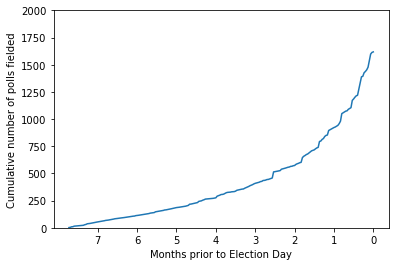

In [9]:
num_polls = df.groupby("t").count()["n"].cumsum().values
plt.plot(range(len(num_polls)), num_polls)
plt.xticks(range(len(num_polls)-1, 0, -30), list(range(0,8,1)))
plt.ylim(0, 2000)
num_polls[list(range(0, len(num_polls)+1, 30))]
plt.xlabel("Months prior to Election Day")
plt.ylabel("Cumulative number of polls fielded")

---
## 4.2. Results
---
In this paper, a large number of political and economic parameters are estimated using relatively few polls. Therefore, a prior data is implemented for effective and accurate estimation. These are related to the priors we chose, the indicators in the fundamentals-based forecast, and the covariance matrix that provides data across states. As a result, the model's output is affected by these selections. Instead of predicting the outcome of an election, we forecast voting intentions. The Electoral College prediction is based on our vote estimations for each state.

As we mentioned above, Voters do not choose the president; rather, they authorize their state's electoral-college electors on how to vote. In the majority of states, all electors vote in accordance with popular sentiment in the state. For example, if Hillary Clinton receives more than 50 percent of the vote in Pennsylvania, all 20 of the state's electors will vote for her — but nobody will vote for Donald Trump. To win the presidency, a candidate must receive at least 270 electoral votes. 

The election was held on November 8, 2016. The polls were conducted between March 1, 2016, and November 7, 2016 -  over the course of 233 days.

---
### 4.2.1. Electoral College Simulations
---

We simulate 3000 paths for each day polled and each state. The model is analyzed by implementing daily state-level and national polls with economic and political factors such as fundamentals, urbanicity, white evangelists, race statistics. For each time frame, the candidates' vote shares are modified to compensate for sampling error, differences in the participation rate, or changes in the political environment, as well as the impacts of campaigning. One should note that the model ignores Maine's and Nebraska's unique electoral vote distribution rules (Kremp, 2020). 

---
### 4.2.2. National Vote Trends
---

The weighted average of state-by-state vote estimates was implemented to calculate Clinton's share of the two parties' national vote. The model of national vote estimates is defined in Section 3.1. The thick line denotes the median of the posterior distribution of national vote estimates, while the light blue area denotes the 90% confidence are. The 3000 draws from the posterior distribution are denoted by the thin blue lines. Towards election day, Clinton's national vote share is represented by a dotted black line and estimated to decrease slowly, returning to the fundamentals-based prior. Clinton's national poll numbers are generally lower than the expected level based on state-level estimates. 

---
### 4.2.3. State-by-State Trends
---
We forecast the probabilities of vote intentions in each state using public polls from the HuffPost Pollster database. To simulate, we use a dynamic Bayesian forecasting model (Linzer, 2013). The simulations are run until election day. Because we don't have further polling data, the definition implies voter behaviours will generally follow their current paths. When more and more polls are released, forecasts will become more accurate. We integrate forecasts by providing the fundamentals-based estimation the prior for election day. The previous random walk can be illustrated as a time travel from election Day to the actual polling day. As a result, the poll-based forecast for election day is used to adjust the model's prior for Election Day. The following graphs show the vote inventions for each state. 


#### Figure a. State Vote

In [3]:
# Retrieve STAN Model Output in a dataframe
out = pd.read_csv("data/all_predictions.csv")

In [4]:
elect = ELECTION_2016()

<Figure size 576x1440 with 0 Axes>

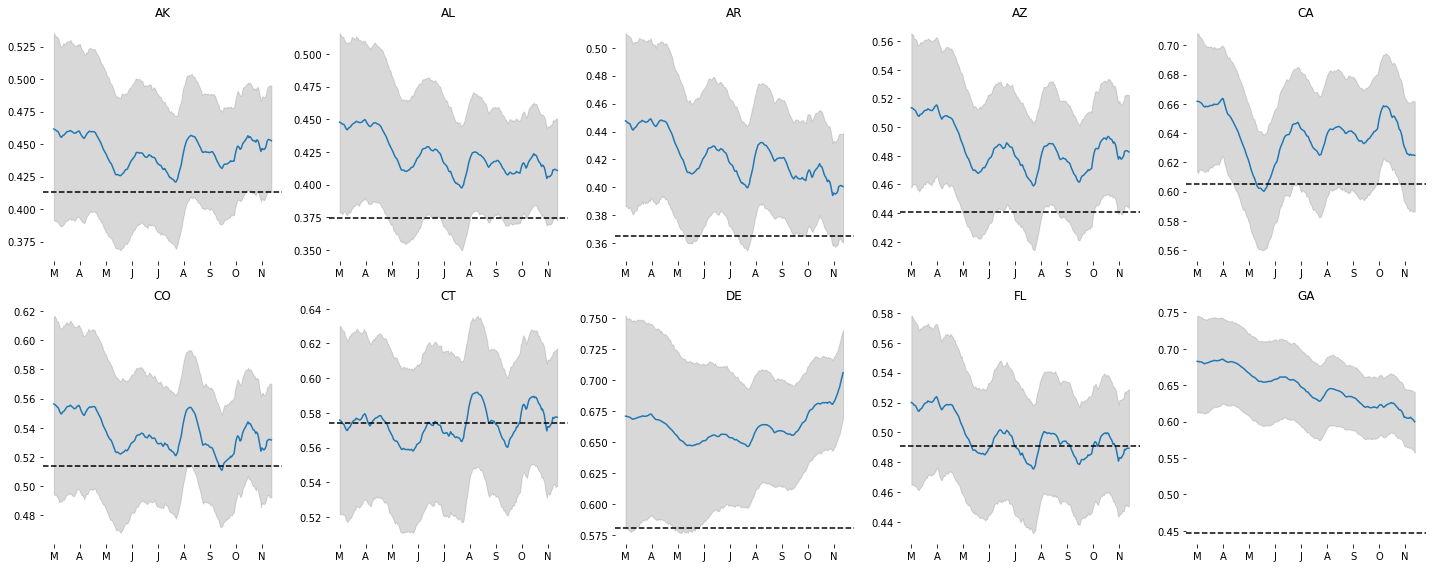

<Figure size 576x1440 with 0 Axes>

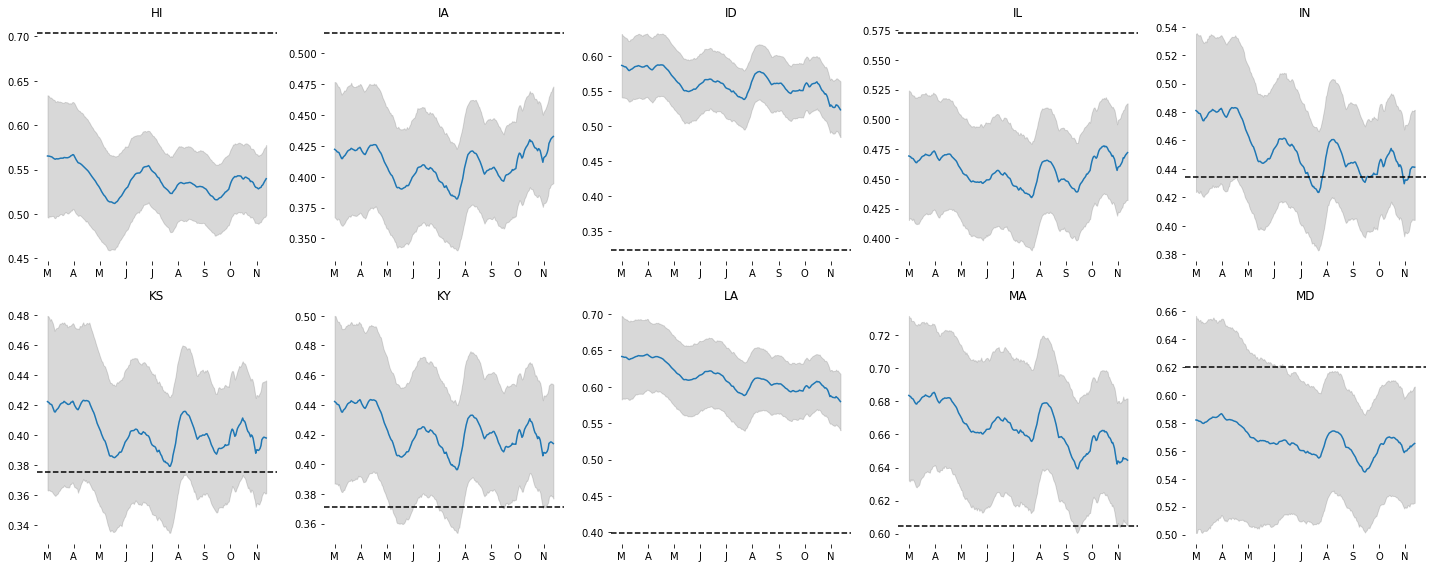

<Figure size 576x1440 with 0 Axes>

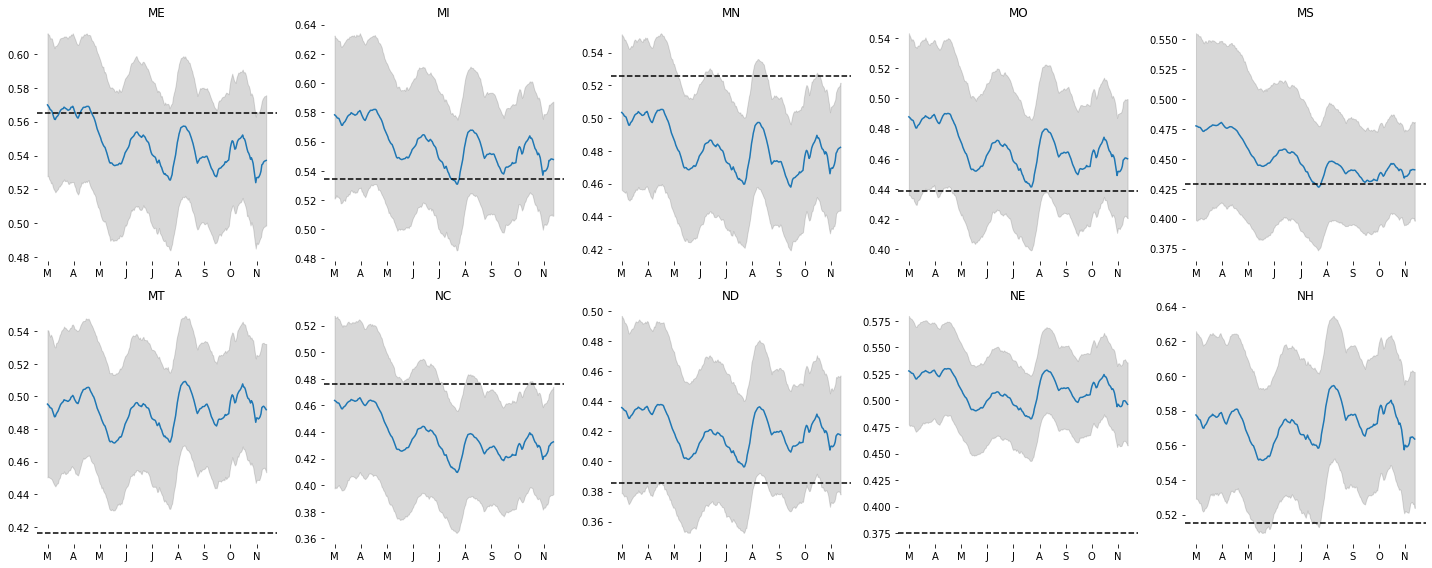

<Figure size 576x1440 with 0 Axes>

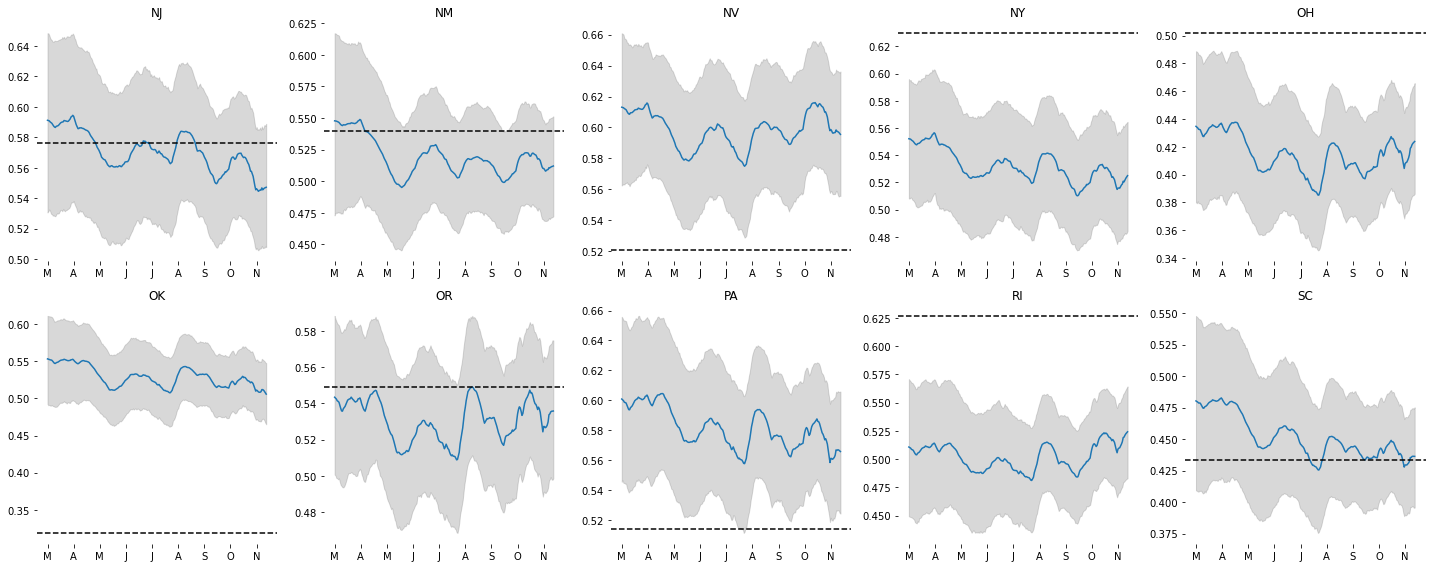

<Figure size 576x1440 with 0 Axes>

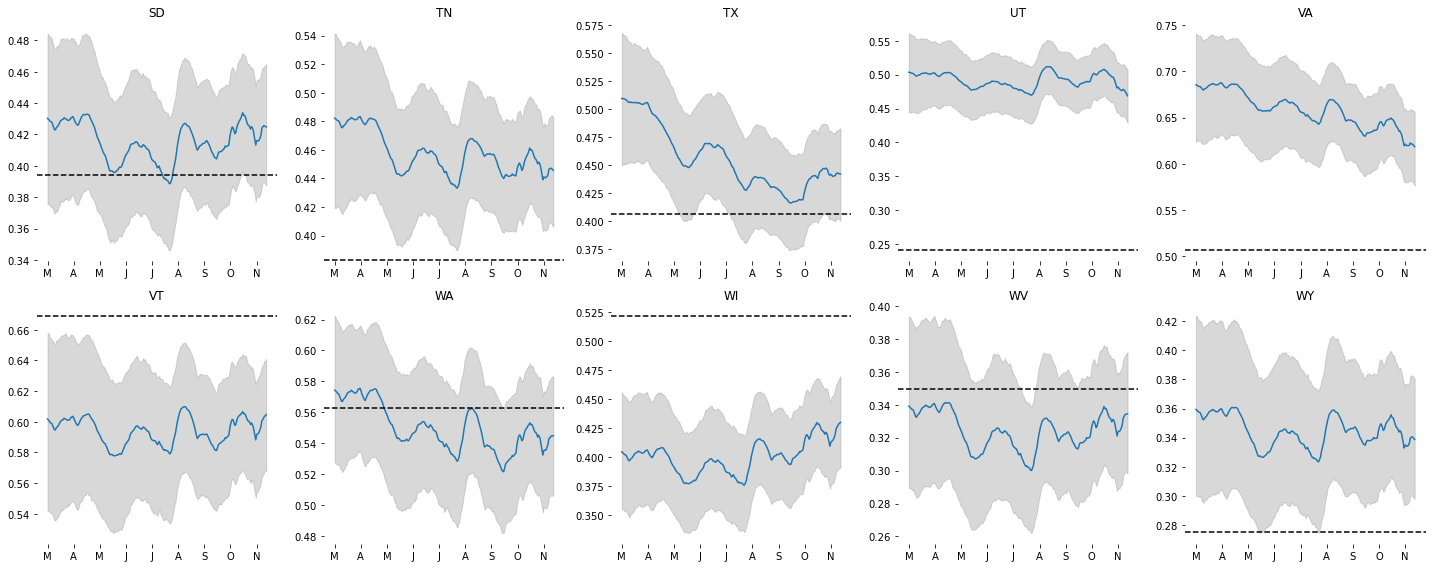

In [9]:
plt.rcParams["figure.figsize"] = (20,8)
states = elect.get_plots("states", out)

The following figure illustrates the prior and posterior Clinton vote shares for each state. The orange line represents the prior values and the blue line the posterior values. As in most elections, the western states were strongholds for the Democrats, while the southern states again provided support for the Republicans. As in most elections, the western states are expected to be strongholds for the Democrats and the southern states for the Republicans.

    #### Figure a.ds. State-by-State Probabilities

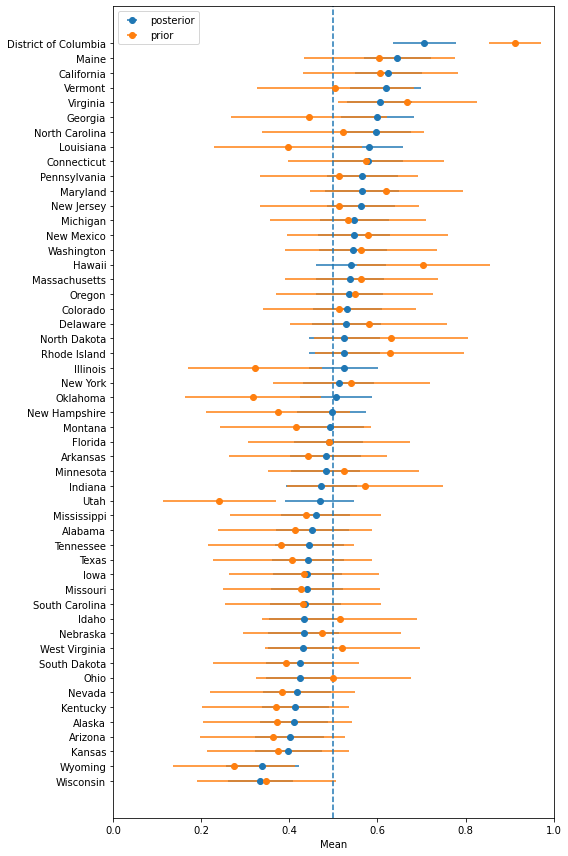

In [9]:
state_by_state = elect.get_plots("mu_b", out)

The map below depicts the country, with each state colored by the probability of candidates' vote share.

#### Figure 3. Map of State Probabilities

---
### 4.2.4. Pollster, Population and Mode Effects
---

Adjustment features for pollsters, polled population (e.g., likely voters and registered voters), and polling mode (e.g. live phone or online) are used. Pollsters can support parties and be partizan, and that the same holds true for the polled population and the methods used to poll the voters. Therefore, vote intentions should be adjusted according to these effects and, the weighted averages of all of them were added to the analysis. The error distributions of adjusters are defined in Section 3.1. The following figure shows the pollster adjustments and is based on the Clinton vote share. The orange line represents the prior values and the blue line the posterior values. Polsters are placed vertically from most pro-Clinton pollster to most pro-Trump pollster. As expected, it is clear from the figure that many pollsters are biased about the candidates.

        #### Figure AAAA.            Pollster Adjustment

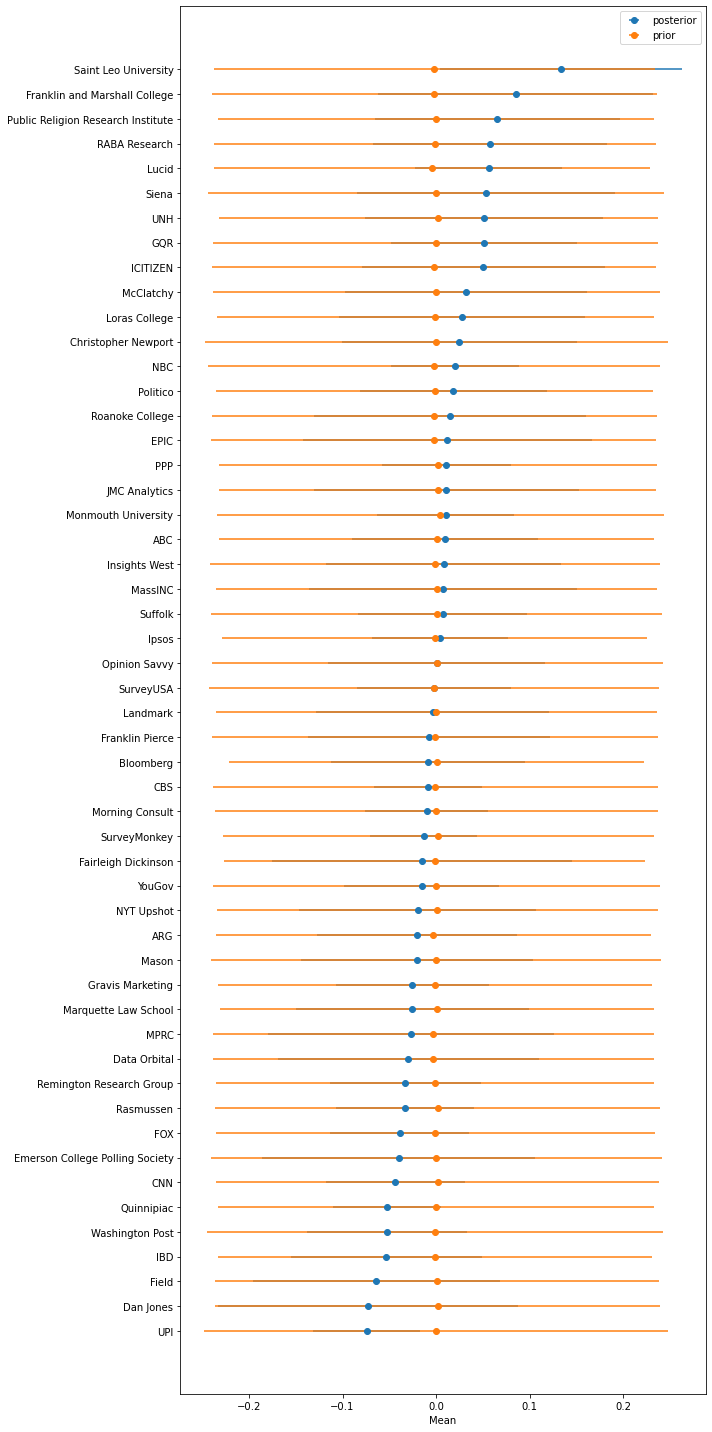

In [5]:
pollster = elect.get_plots("mu_c", out)


We have mentioned above that we divide the methods of conducting the surveys into 3 categories: live phone, online and other methods. The next figure shows how partisanship should be adjusted according to poll methods. While it was observed that the live phone respondents were pro-Clinton, it was determined that the voters reached by other methods were pro-Trump.

    #### Figure Â. Mode Adjustment

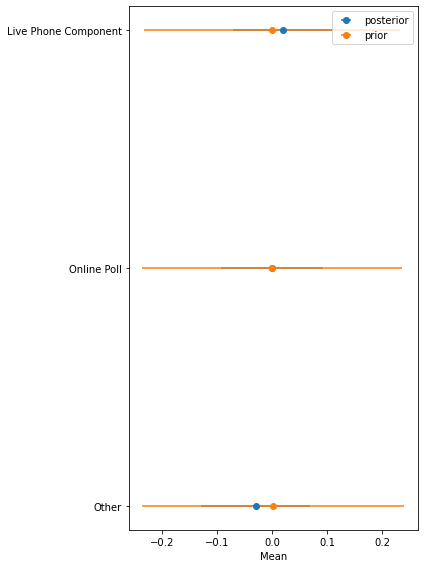

In [6]:
mode = elect.get_plots("mu_m", out)


The polled voter population was also analyzed in 3 groups: adults, likely voters and, registered voters. The figure below shows how voters' support for a party is affected by their characteristics. While it has been observed that registered voters tend to vote in favor of Trump, it has been observed that adult voters tend to be pro-Clinton.

    #### Figure 11111111111. Population Adjustment

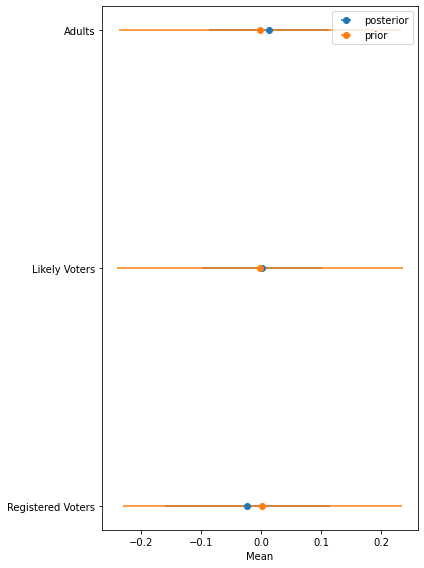

In [7]:
population = elect.get_plots("mu_pop", out)

---
# 5. Conclusion
---
In this project we studied the Bayesian Forecasting model in order to predict the upcoming U.S presidential election outcomes at the state level. This model mainly considers the large number of state-level opinion surveys as well as information from the historical forecasting models. The end result is a set of data that has an increasing accuracy as the election day approaches. To borrow strength both across state and through the use of random-walk priors, here we employed hierarchical specification. This is done for the purpose of overcoming the limitation that not every state is polled regularly. Moreover, in order to handle the daily tracking of voter preferences towards the presidential candidates, this model sifts through day-to-day variations in the polls caused by sampling error and national campaign effects. We also used simulation techniques to estimate the candidates’ winning chance and thus the winning chance of Electoral College. When this model is applied to 2008 presidential campaign, the victory of Hillary Clinton was never, in fact, in doubt. However, at the end Donald Trump was the winner.We aim to help the researchers to refine and update structural state-level election forecasts by describing an integrated modeling framework. This model will mainly rely on the results of every newly available state-level opinion poll. We used the older polls to estimate the past trends in state level opinion as they provide less data for forecasting. This model also borrows strength hierarchically across both states and days of the campaign in order to handle the uneven spacing of the prelection polls. Moreover, when a significant event occurs that will affect the short-term mass opinion, such as party conventions or major news, this model has the capacity to detect and account it on how it will affect the campaigns.

Due to the time constraint, we could not analyze why our forecast provide wrong results. In fact, we know that many of the forecast models that year were not accurate. Although it was a failure for the US election forecasts made in 2016, the reason for this deviation and inconsistency should be investigated and analyzed in future studies.


---
# 6. References
---

*   Abramowitz, A. I. (2008). Forecasting the 2008 presidential election with the time-for-change model. PS: Political Science & Politics, 41, 691–695.

*   Heidemanns, M., Gelman, A., & Morris, G. E. (2020). An Updated Dynamic Bayesian Forecasting Model for the US Presidential Election. Harvard Data Science Review, 2(4). https://doi.org/10.1162/99608f92.fc62f1e1

* Huffingtonpost, (2016). 2016 Senate Races. Retrieved from https://elections.huffingtonpost.com/pollster#2016-senate-races

* Kremp, P. A. (2020). State and National Poll Aggregation.

* Linzer, D. A. (2013). Dynamic Bayesian forecasting of presidential elections in the states. Journal of the American Statistical Association, 108, 124–134.



